https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb

# Dependencies

In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 512kB 55.5MB/s 
     |████████████████████████████████| 3.8MB 25.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=96110f747778cd64d1edf249ab3c587f5f5790d7ef06f6b5f924a1bb01d81988
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [1]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv1D, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


# GAN

In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 128
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = cifar10.load_data()
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
               self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

# Train

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=64, sample_interval=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.718690, acc.: 61.72%] [G loss: 0.699021]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.476767, acc.: 94.53%] [G loss: 0.571711]
2 [D loss: 0.408135, acc.: 96.09%] [G loss: 0.460248]
3 [D loss: 0.435601, acc.: 77.34%] [G loss: 0.414977]
4 [D loss: 0.470995, acc.: 64.06%] [G loss: 0.386232]
5 [D loss: 0.445369, acc.: 68.75%] [G loss: 0.403903]
6 [D loss: 0.440140, acc.: 69.53%] [G loss: 0.459455]
7 [D loss: 0.413838, acc.: 77.34%] [G loss: 0.494968]
8 [D loss: 0.404921, acc.: 84.38%] [G loss: 0.536065]
9 [D loss: 0.359225, acc.: 79.69%] [G loss: 0.618312]
10 [D loss: 0.400368, acc.: 80.47%] [G loss: 0.718355]
11 [D loss: 0.410000, acc.: 79.69%] [G loss: 0.754293]
12 [D loss: 0.441538, acc.: 77.34%] [G loss: 0.894769]
13 [D loss: 0.391989, acc.: 82.03%] [G loss: 0.957287]
14 [D loss: 0.451104, acc.: 78.91%] [G loss: 1.097265]
15 [D loss: 0.445648, acc.: 80.47%] [G loss: 1.204779]
16 [D loss: 0.410048, acc.: 82.03%] [G loss: 1.295283]
17 [D loss: 0.303842, acc.: 91.41%] [G loss: 1.331729]
18 [D loss: 0.313223, acc.: 88.28%] [G loss: 1.417209]
19 [D loss: 0.36174

# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

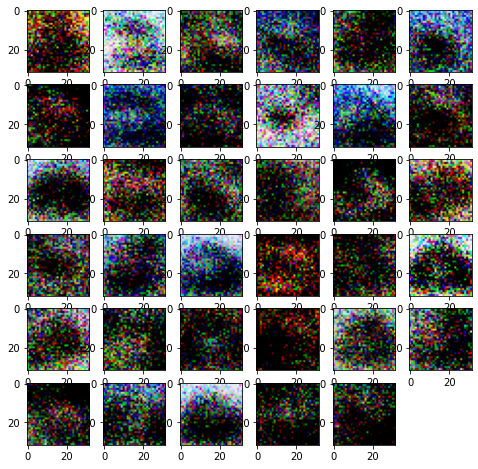

In [6]:
noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()